## Regressão logística - Variáveis agregadas (2010 a 2017)

### Bibliotecas e bases de dados

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

#Estilizar conteúdo
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    def cor_linhas(row):
        if row.name % 2 == 0:
            return ['background-color: #ffffff'] * len(row)
        else:
            return ['background-color: #f9f9f9'] * len(row)
    
    return (
        df.style.apply(cor_linhas, axis=1) 
        .set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},  # Azul abaixo do nome das colunas
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '300px')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},
            ]
        )
        .set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        )
        .set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        )
        .format(
            precision=casas_decimais  
        )
    )

# Base de dados

df_eventos_2010_2017_modelo1 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2010_2017_modelo1.csv",
    sep=';',
    decimal=',',
)

### Ajustes da base de dados

In [2]:
# Remover linhas com dados ausentes

df_eventos_2018_2024_modelo1 = df_eventos_2010_2017_modelo1.dropna()

estilo_tabelas(df_eventos_2010_2017_modelo1.head(5))

,Status,DH_total_danos_humanos,DM_total_danos_materiais,PEPL_total_publico,PEPR_total_privado,regiao_Centro-oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500,Rendapercapita
0,0,4000,166542.286,6120428.994,7286224.972,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,17.934
1,0,8034,0.000,0.000,7639477.192,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.605
2,0,2732,0.000,0.000,26406.490,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,13.655
3,0,0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.997
4,0,0,2048392.375,2617.833,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.594


### Treino e teste

In [3]:
X_2010_2017_modelo1 = df_eventos_2010_2017_modelo1.drop('Status', axis=1)

y_2010_2017_modelo1 = df_eventos_2010_2017_modelo1['Status']

X_train_2010_2017_modelo1, X_test_2010_2017_modelo1, y_train_2010_2017_modelo1, y_test_2010_2017_modelo1 = train_test_split(X_2010_2017_modelo1, y_2010_2017_modelo1, test_size=0.2, random_state=1, stratify=y_2010_2017_modelo1)

### Resultados - sem balanceamento

In [4]:
# Criar pipeline com normalização e modelo de Regressão Logística
pipeline_2010_2017_modelo1 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=1, solver='lbfgs'))
])

# Definir hiperparâmetros para o Grid Search
param_grid_2010_2017_modelo1 = {
    'logreg__C': [0.01, 0.1, 1, 10],  # Regularização
    'logreg__max_iter': [1000],  # Número máximo de iterações
    'logreg__fit_intercept': [True, False],  # Se deve ajustar o intercepto
    'logreg__tol': [1e-4, 1e-3],  # Tolerância para convergência
    'logreg__penalty': ['l1', 'l2'],  # Tipos de penalidade
}

# Grid Search com validação cruzada
grid_search_2010_2017_modelo1 = GridSearchCV(pipeline_2010_2017_modelo1, param_grid_2010_2017_modelo1, cv=3, scoring='f1_weighted', n_jobs=-1)
1
grid_search_2010_2017_modelo1.fit(X_train_2010_2017_modelo1, y_train_2010_2017_modelo1)

# Melhor modelo encontrado
logreg_best_2010_2017_modelo1 = grid_search_2010_2017_modelo1.best_estimator_

print(f"Melhores hiperparâmetros: {grid_search_2010_2017_modelo1.best_params_}")

# F1 score no conjunto de teste
y_pred_2010_2017_modelo1 = logreg_best_2010_2017_modelo1.predict(X_test_2010_2017_modelo1)

f1_2010_2017_modelo1 = f1_score(y_test_2010_2017_modelo1, y_pred_2010_2017_modelo1, average='weighted')
print(f"F1 Score: {f1_2010_2017_modelo1:.6f}")

classification_report_2010_2017_modelo1 = metrics.classification_report(y_test_2010_2017_modelo1, y_pred_2010_2017_modelo1, digits=6, target_names=['Reconhecido', 'Não reconhecido'])
print('Classification report para modelo 1 (2010 - 2017): \n')
print(classification_report_2010_2017_modelo1)

Melhores hiperparâmetros: {'logreg__C': 1, 'logreg__fit_intercept': False, 'logreg__max_iter': 1000, 'logreg__penalty': 'l2', 'logreg__tol': 0.0001}
F1 Score: 0.875884
Classification report para modelo 1 (2010 - 2017): 

                 precision    recall  f1-score   support

    Reconhecido   0.913793  0.986881  0.948932      2363
Não reconhecido   0.465517  0.109312  0.177049       247

       accuracy                       0.903831      2610
      macro avg   0.689655  0.548096  0.562991      2610
   weighted avg   0.871370  0.903831  0.875884      2610



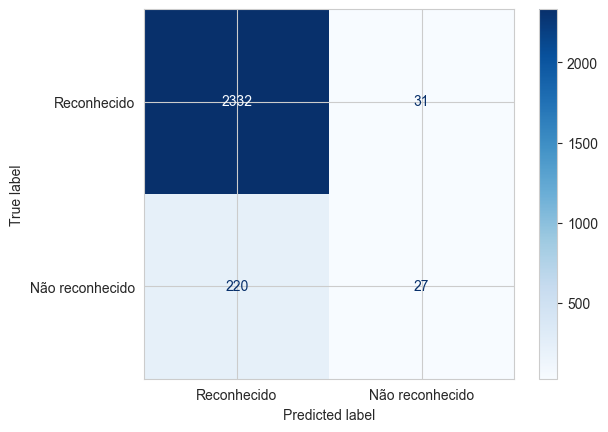

In [5]:
ConfusionMatrixDisplay.from_estimator(grid_search_2010_2017_modelo1, X_test_2010_2017_modelo1, y_test_2010_2017_modelo1, 
                                      values_format='d', cmap='Blues', display_labels=['Reconhecido', 'Não reconhecido'])

### Resultados - com balanceamento SMOTE

In [6]:
smote = SMOTE(random_state=1)
X_train_smote_2010_2017_modelo1_, y_train_smote_2010_2017_modelo1 = smote.fit_resample(X_train_2010_2017_modelo1, y_train_2010_2017_modelo1)

pipeline_2010_2017_modelo1 = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(random_state=1, solver='lbfgs'))  
])

# Definir hiperparâmetros para o Grid Search
param_grid_2010_2017_modelo1 = {
    'logreg__C': [0.01, 0.1, 1, 10],  
    'logreg__max_iter': [1000],  
    'logreg__fit_intercept': [True, False],
    'logreg__tol': [1e-4, 1e-3],
    'logreg__penalty': ['l1', 'l2'],
}

# Grid Search com validação cruzada
grid_search_2010_2017_modelo1 = GridSearchCV(pipeline_2010_2017_modelo1, param_grid_2010_2017_modelo1, cv=3, scoring='f1_weighted', n_jobs=-1)

# Treinar o pipeline com Grid Search
grid_search_2010_2017_modelo1.fit(X_train_smote_2010_2017_modelo1_, y_train_smote_2010_2017_modelo1)

# Melhor modelo encontrado
logreg_best_2010_2017_modelo1 = grid_search_2010_2017_modelo1.best_estimator_

print(f"Melhores hiperparâmetros: {grid_search_2010_2017_modelo1.best_params_}")

# F1 score no conjunto de teste
y_pred_2010_2017_modelo1_smote = logreg_best_2010_2017_modelo1.predict(X_test_2010_2017_modelo1)

f1_smote_2010_2017_modelo1 = f1_score(y_test_2010_2017_modelo1, y_pred_2010_2017_modelo1_smote, average='weighted')
print(f"F1 Score: {f1_smote_2010_2017_modelo1:.6f}")

classification_report_smote_2010_2017_modelo1 = metrics.classification_report(y_test_2010_2017_modelo1, y_pred_2010_2017_modelo1_smote, digits=6, target_names=['Reconhecido', 'Não reconhecido'])
print('Classification report para modelo 1 com smote (2010 - 2017): \n')
print(classification_report_smote_2010_2017_modelo1)

Melhores hiperparâmetros: {'logreg__C': 10, 'logreg__fit_intercept': True, 'logreg__max_iter': 1000, 'logreg__penalty': 'l2', 'logreg__tol': 0.001}
F1 Score: 0.798037
Classification report para modelo 1 com smote (2010 - 2017): 

                 precision    recall  f1-score   support

    Reconhecido   0.947808  0.768515  0.848796      2363
Não reconhecido   0.211816  0.595142  0.312434       247

       accuracy                       0.752107      2610
      macro avg   0.579812  0.681828  0.580615      2610
   weighted avg   0.878157  0.752107  0.798037      2610

